In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import soundfile as sf
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
assert torch.cuda.is_available()

In [3]:
import sys
sys.path.append('../')
from data import LibriSpeechDataset

In [4]:
n_seconds = 3
base_sampling_rate = 16000
downsampling = 4
batchsize = 8

In [5]:
trainset = LibriSpeechDataset('train-clean-100',base_sampling_rate*n_seconds)
testset = LibriSpeechDataset('dev-clean',base_sampling_rate*n_seconds)

Indexing data...
Finished indexing data. 27949 usable files found.
Indexing data...
Finished indexing data. 2303 usable files found.


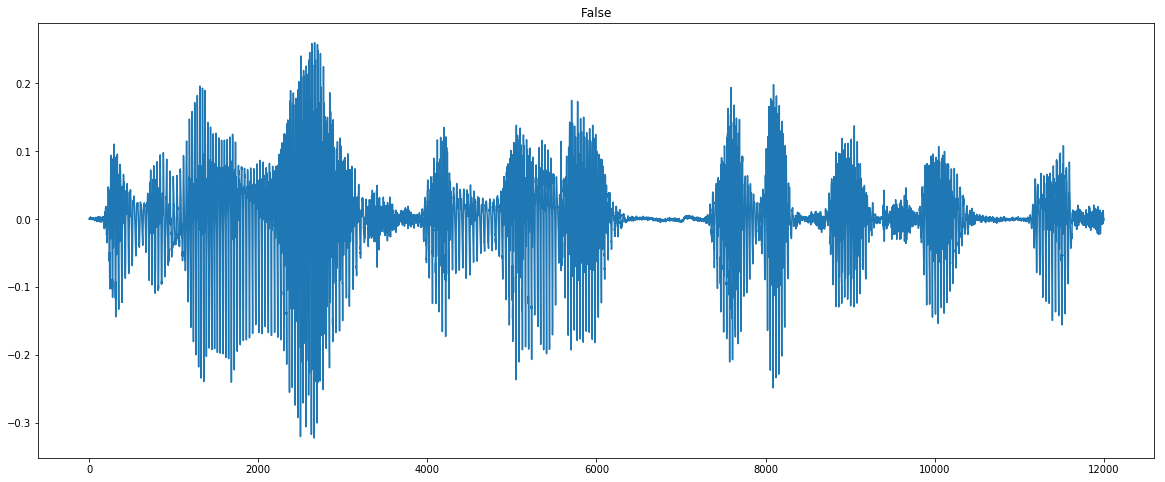

In [6]:
instance, label = trainset[np.random.randint(0,len(trainset))]

plt.figure(figsize=(20,8))
plt.title(label)
plt.plot(instance[::downsampling])
plt.show()

In [7]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batchsize,num_workers=4,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=batchsize,num_workers=4,shuffle=True)

In [8]:
instance[::downsampling].shape

(12000,)

### Define model

In [9]:
class TestNet(nn.Module):
    def __init__(self, filters, dilation_depth, dilation_stacks):
        super(TestNet, self).__init__()
        self.filters = filters
        self.dilation_depth = dilation_depth
        self.dilation_stacks = dilation_stacks

        self.initialconv = nn.Conv1d(1 ,filters ,3 ,dilation=1 ,padding=1)
                
        self.dilated_conv_1_relu_s0 = nn.Conv1d(filters,filters,3,dilation=1,padding=1)
        self.dilated_conv_2_relu_s0 = nn.Conv1d(filters,filters,3,dilation=2,padding=2)
        self.dilated_conv_4_relu_s0 = nn.Conv1d(filters,filters,3,dilation=4,padding=4)
        self.dilated_conv_8_relu_s0 = nn.Conv1d(filters,filters,3,dilation=8,padding=8)
        self.dilated_conv_16_relu_s0 = nn.Conv1d(filters,filters,3,dilation=16,padding=16)
        self.dilated_conv_32_relu_s0 = nn.Conv1d(filters,filters,3,dilation=32,padding=32)
        self.dilated_conv_64_relu_s0 = nn.Conv1d(filters,filters,3,dilation=64,padding=64)
        self.dilated_conv_128_relu_s0 = nn.Conv1d(filters,filters,3,dilation=128,padding=128)
        
        self.finalconv = nn.Conv1d(filters,filters ,3 ,dilation=1 ,padding=1)

        self.output = nn.Linear(filters ,1)

    def forward(self, x):
        x = x.cuda().double()
        x = self.initialconv(x)
        
        original_x = x
        x = F.relu(self.dilated_conv_1_relu_s0(x))
        x = x + original_x
        original_x = x
        x = F.relu(self.dilated_conv_2_relu_s0(x))
        x = x + original_x
        original_x = x
        x = F.relu(self.dilated_conv_4_relu_s0(x))
        x = x + original_x
        original_x = x
        x = F.relu(self.dilated_conv_8_relu_s0(x))
        x = x + original_x
        original_x = x
        x = F.relu(self.dilated_conv_16_relu_s0(x))
        x = x + original_x
        original_x = x
        x = F.relu(self.dilated_conv_32_relu_s0(x))
        x = x + original_x
        original_x = x
        x = F.relu(self.dilated_conv_64_relu_s0(x))
        x = x + original_x
        original_x = x
        x = F.relu(self.dilated_conv_128_relu_s0(x))
        x = x + original_x
        
        x = F.relu(self.finalconv(x))


        x = F.max_pool1d(x, kernel_size=x.size()[2:])
        x = x.view(-1 ,self.filters)
        x = F.sigmoid(self.output(x))
        return x

In [10]:
for s in range(1):
    for i in range(8):
#         print 'self.dilated_conv_{}_relu_s{} = nn.Conv1d(filters,filters,3,dilation={},padding={})'.format(
#             2**i ,s, 2**i , 2**i
#         )
        print 'original_x = x'
        print 'x = F.relu(self.dilated_conv_{}_relu_s{}(x))'.format(2**i ,s)
        print 'x = x + original_x'

original_x = x
x = F.relu(self.dilated_conv_1_relu_s0(x))
x = x + original_x
original_x = x
x = F.relu(self.dilated_conv_2_relu_s0(x))
x = x + original_x
original_x = x
x = F.relu(self.dilated_conv_4_relu_s0(x))
x = x + original_x
original_x = x
x = F.relu(self.dilated_conv_8_relu_s0(x))
x = x + original_x
original_x = x
x = F.relu(self.dilated_conv_16_relu_s0(x))
x = x + original_x
original_x = x
x = F.relu(self.dilated_conv_32_relu_s0(x))
x = x + original_x
original_x = x
x = F.relu(self.dilated_conv_64_relu_s0(x))
x = x + original_x
original_x = x
x = F.relu(self.dilated_conv_128_relu_s0(x))
x = x + original_x


In [11]:
from models import WaveNet
model = TestNet(128, 8, 1)
model.double()
model.cuda()

TestNet(
  (initialconv): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (dilated_conv_1_relu_s0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (dilated_conv_2_relu_s0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
  (dilated_conv_4_relu_s0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
  (dilated_conv_8_relu_s0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
  (dilated_conv_16_relu_s0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
  (dilated_conv_32_relu_s0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
  (dilated_conv_64_relu_s0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
  (dilated_conv_128_relu_s0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
  (finalconv): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,

In [12]:
skip = np.random.randint(0,100)
for i, data in enumerate(testloader):
    if i != skip:
        continue
    timeseries, labels = data
    break
timeseries = timeseries.reshape((batchsize,1,base_sampling_rate*n_seconds))[:,:,::downsampling]
predicted = model(timeseries)
predicted, labels

(tensor([[ 0.5599],
         [ 0.5691],
         [ 0.5656],
         [ 0.5597],
         [ 0.5549],
         [ 0.5634],
         [ 0.5577],
         [ 0.5603]], dtype=torch.float64, device='cuda:0'),
 tensor([ 0,  1,  1,  0,  1,  1,  0,  0]))

In [13]:
timeseries.numpy().reshape((batchsize,int(base_sampling_rate*n_seconds/downsampling))).std(axis=1)

array([0.0566315 , 0.06228517, 0.07479737, 0.09487321, 0.01616078,
       0.04886637, 0.04222218, 0.09516351])

In [14]:
timeseries.numpy().reshape((batchsize,int(base_sampling_rate*n_seconds/downsampling))).mean(axis=1)

array([-3.83478800e-05, -7.73162842e-05, -3.61999512e-04,  1.80839539e-04,
        9.35050964e-04, -2.17102051e-04, -1.39617920e-06, -3.07121277e-04])

In [15]:
def evaluate():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            timeseries, labels = data
            if timeseries.shape[0] != batchsize:
                # incomplete batch
                continue
            timeseries = timeseries.reshape((batchsize,1,base_sampling_rate*n_seconds))[:,:,::downsampling]
            predicted = model(timeseries)
            total += labels.size(0)
            correct += ((predicted > 0.5)[:,0] == labels.cuda().byte()).cpu().sum().numpy()
            
    return correct*1.0/total

In [19]:
criterion = nn.BCELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(),lr=0.0001)

In [20]:
torch.backends.cudnn.benchmark = True

In [21]:
print_every = 100
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        if inputs.shape[0] != batchsize:
            # incomplete batch
            continue
                
        inputs = inputs.reshape((batchsize,1,base_sampling_rate*n_seconds))[:,:,::downsampling]
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels.reshape((batchsize,1)).cuda().double())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % print_every == print_every - 1:    # print every 'print_every' mini-batches
            val_acc = evaluate()
#             val_acc = 0.0
            print('[%d, %5d] loss: %.3f  val_acc: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every, val_acc))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.115  val_acc: 0.939
[1,   200] loss: 0.095  val_acc: 0.938
[1,   300] loss: 0.090  val_acc: 0.940
[1,   400] loss: 0.121  val_acc: 0.930
[1,   500] loss: 0.066  val_acc: 0.936
[1,   600] loss: 0.088  val_acc: 0.935
[1,   700] loss: 0.095  val_acc: 0.934
[1,   800] loss: 0.098  val_acc: 0.928
[1,   900] loss: 0.099  val_acc: 0.938
[1,  1000] loss: 0.086  val_acc: 0.938
[1,  1100] loss: 0.087  val_acc: 0.936
[1,  1200] loss: 0.082  val_acc: 0.943
[1,  1300] loss: 0.081  val_acc: 0.934
[1,  1400] loss: 0.071  val_acc: 0.943
[1,  1500] loss: 0.069  val_acc: 0.937
[1,  1600] loss: 0.077  val_acc: 0.938
[1,  1700] loss: 0.072  val_acc: 0.937
[1,  1800] loss: 0.081  val_acc: 0.937
[1,  1900] loss: 0.086  val_acc: 0.937
[1,  2000] loss: 0.103  val_acc: 0.934
[1,  2100] loss: 0.081  val_acc: 0.936
[1,  2200] loss: 0.094  val_acc: 0.929
[1,  2300] loss: 0.073  val_acc: 0.936
[1,  2400] loss: 0.102  val_acc: 0.928
[1,  2500] loss: 0.090  val_acc: 0.933
[1,  2600] loss: 0.070  v

Process Process-312:
Process Process-309:
Process Process-444:
Process Process-310:
Process Process-311:
Traceback (most recent call last):
Process Process-442:
Process Process-441:
Process Process-443:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in 

KeyboardInterrupt: 

In [ ]:
evaluate()